# Assembling the proxy database from the LiPDVerse

⚠️ **Warning** 

This notebook contains a cell that starts a widget to help with identifying duplicates in the database. We strongly advise that you do not run the widget yourself unless you intend to go through the cleaning process. A list of removed datasets (TSiDS) and the reason they were removed or kept is stored in csv files in this repository. The resulting cleaned database has also been saved in a pickle file. 

<div style="border-left: 6px solid #e74c3c; background-color: #f8d7da; padding: 10px; margin: 10px 0;">
  <strong>❗ DO NOT RUN ALL!!!!!!  
</div>

## Authors

[Deborah Khider](https://orcid.org/0000-0001-7501-8430) &
[Julien Emile-Geay](https://orcid.org/0000-0001-5920-4751)


## Goal

The goal of this notebook is to showcase data querying on the LiPDverser to create the proxy database

## Data Description

This notebook makes use of the [`LiPDVerse` database](https://lipdverse.org), which contains datasets from various working groups. For a list of these compilations, see [this page](https://lipdverse.org/project/). 

In particular, we will be using [PAGES2kTemperature](https://lipdverse.org/project/pages2k/), [iso-2k](https://lipdverse.org/project/iso2k/), and [CoralHydro2k](https://lipdverse.org/project/coralhydro2k/) compilations for this demonstration.

* PAGES2k: PAGES2k Consortium., Emile-Geay, J., McKay, N. et al. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). doi:10.1038/sdata.2017.88

* iso2k: Konecky, B. L., McKay, N. P., Churakova (Sidorova), O. V., Comas-Bru, L., Dassié, E. P., DeLong, K. L., Falster, G. M., Fischer, M. J., Jones, M. D., Jonkers, L., Kaufman, D. S., Leduc, G., Managave, S. R., Martrat, B., Opel, T., Orsi, A. J., Partin, J. W., Sayani, H. R., Thomas, E. K., Thompson, D. M., Tyler, J. J., Abram, N. J., Atwood, A. R., Cartapanis, O., Conroy, J. L., Curran, M. A., Dee, S. G., Deininger, M., Divine, D. V., Kern, Z., Porter, T. J., Stevenson, S. L., von Gunten, L., and Iso2k Project Members: The Iso2k database: a global compilation of paleo-δ18O and δ2H records to aid understanding of Common Era climate, Earth Syst. Sci. Data, 12, 2261–2288, https://doi.org/10.5194/essd-12-2261-2020, 2020.

* CoralHydro2k:  Walter, R. M., H. R. Sayani, T. Felis, K. M. Cobb, N. J. Abram, A. K. Arzey, A. R. Atwood, L. D.
Brenner, E. P. Dassi ́e, K. L. DeLong, B. Ellis, J. Emile-Geay, M. J. Fischer, N. F. Goodkin, J. A.
Hargreaves, K. H. Kilbourne, H. Krawczyk, N. P. McKay, A. L. Moore, S. A. Murty, M. R. Ong,
R. D. Ramos, E. V. Reed, D. Samanta, S. C. Sanchez, J. Zinke, and the PAGES CoralHydro2k Project Members (2023), The CoralHydro2k database: a global, actively curated compilation of coral δ18O and Sr / Ca proxy records of tropical ocean hydrology and temperature for the Common Era, Earth System Science Data, 15(5), 2081–2116, doi:10.5194/essd-15-2081-2023.

Let's start by downloading the datasets.

<div style="border-left: 4px solid #d62728; background-color: #ffe6e6; padding: 0.75em 1em; border-radius: 6px; font-size: 0.95em;">
  <strong>⚠️ Warning:</strong> You only need to run the cell below once. It will download the data locally. The rest of the notebook assumes that the data is organized according to the output of the cell below.
</div>

In [1]:
# URL Links to download the data

pages2k_url = "https://lipdverse.org/Pages2kTemperature/current_version/Pages2kTemperature2_2_0.zip"
iso2k_url = "https://lipdverse.org/iso2k/current_version/iso2k1_1_2.zip"
coral2k_url ="https://lipdverse.org/CoralHydro2k/current_version/CoralHydro2k1_0_1.zip"

urls = [pages2k_url,iso2k_url,coral2k_url]
folders = ['Pages2k', 'iso2k', 'coral2k']

# import the necessary packages
import os
import requests
import zipfile
from pathlib import Path

## PAGES2k
# Define folder path and URL
for idx,url in enumerate(urls):
    folder_path = Path(f"./data/{folders[idx]}")
    zip_path = folder_path.with_suffix('.zip')

    # Step 1: Check if folder exists, create if not
    folder_path.mkdir(parents=True, exist_ok=True)

    # Step 2: Check if folder is empty
    if not any(folder_path.iterdir()):
        print("Folder is empty. Downloading data...")

        # Step 3: Download zip file
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded ZIP to {zip_path}")

        # Step 4: Extract zip contents into folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        print(f"Extracted contents to {folder_path}")


## Exploring the records in each of the compilations

Let's start with importing the needed packages:

In [2]:
import os

# General data manipulation libraries
import numpy as np
import pandas as pd

# To manipulate LiPD files
from pylipd.lipd import LiPD
import json

# Scientific toolboxes
import pyleoclim as pyleo
import seaborn as sns
import cfr
from scipy import stats

#To be able to compare timeseries
from scipy.stats import zscore
from dtaidistance import dtw
from scipy.stats import pearsonr, zscore
import matplotlib.pyplot as plt
import itertools

### PAGES2k

Let's start with the PAGES2k dataset. We can load the entire folder into a [`pylipd.LiPD` object](https://pylipd.readthedocs.io/en/latest/api.html#lipd-pylipd-lipd-lipd):

In [3]:
D_pages2k = LiPD()
D_pages2k.load_from_dir('./data/Pages2k/')

Loading 647 LiPD files


100%|██████████| 647/647 [00:11<00:00, 54.47it/s]

Loaded..


Let's create a query to gather all the necessary information. Since `PyLiPD` is build upon the [`rdflib` library](https://rdflib.readthedocs.io/en/stable/) and `LiPD` is defined as a child of the `Graph` class in `rdflib`, it is possible to directly query a LiPD object using a SPARQL query as in [this tutorial](https://linked.earth/pylipdTutorials/notebooks/L2_a_custom_queries.html):

In [4]:
query = """ PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?dataSetName ?compilationName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_standardName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?paleoData_seasonality ?paleoData_interpName ?paleoData_interpRank 
    ?TSID ?time_variableName ?time_standardName ?time_values
	?time_units where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .

    # Get the archive
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
    
    # Geographical information    
    
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL{?loc wgs84:alt ?geo_meanElev .}
    
    # PaleoData

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .

    # Name
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasStandardVariable ?variable_obj .
    ?variable_obj rdfs:label ?paleoData_standardName .
    
    #Values
    ?var le:hasValues ?paleoData_values .

    #Seasonality
    OPTIONAL{?var le:seasonality ?paleoData_seasonality} .

    #Units
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }

    #Proxy information
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }

    # Compilation
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .
    FILTER (?compilationName = "Pages2kTemperature").
    ?var le:useInGlobalTemperatureAnalysis True .

    # TSiD (should all have them)
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .

    # Interpretation (might be an optional field)
    OPTIONAL{
        ?var le:hasInterpretation ?interp .

        ?interp le:hasVariable ?interpvar .
        BIND(REPLACE(STR(?interpvar), "http://linked.earth/ontology/interpretation#", "") AS ?interpretedVariable_Fallback)
        OPTIONAL { ?interpvar rdfs:label ?interpretedVariable_Label } # Use a temporary variable for the label
        BIND(COALESCE(?interpretedVariable_Label, ?interpretedVariable_Fallback) AS ?paleoData_interpName) # COALESCE into the final variable
        }
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
        ?interp le:hasRank ?paleoData_interpRank .}
    
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
    
        ?interp le:hasSeasonality ?seasonalityURI .
        BIND(REPLACE(STR(?seasonalityURI), "http://linked.earth/ontology/interpretation#", "") AS ?seasonality_Fallback)
        OPTIONAL { ?seasonalityURI rdfs:label ?seasonalityLabel }
        BIND(COALESCE(?seasonalityLabel, ?seasonality_Fallback) AS ?paleoData_seasonality)
    }

    #Time information
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable ?timevar_obj .
    ?timevar_obj rdfs:label ?time_standardName .
    VALUES ?time_standardName {"year"} .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }  
}"""

In [5]:
qres, df_pages2k = D_pages2k.query(query)
df_pages2k.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,Ant-WDC05A.Steig.2013,Pages2kTemperature,Glacier ice,-79.46,-112.09,1806.0,d18O,d18O,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...",permil,d18O,None,Annual,temperature,NaN,Ant_030,year,year,"[2005, 2004, 2003, 2002, 2001, 2000, 1999, 199...",yr AD
1,NAm-MtLemon.Briffa.2002,Pages2kTemperature,Wood,32.50,-110.80,2700.0,MXD,MXD,"[0.968, 0.962, 1.013, 0.95, 1.008, 0.952, 1.02...",None,maximum latewood density,dendrophysical,Summer,temperature,NaN,NAm_568,year,year,"[1568, 1569, 1570, 1571, 1572, 1573, 1574, 157...",yr AD
2,Arc-Arjeplog.Bjorklund.2014,Pages2kTemperature,Wood,66.30,18.20,800.0,density,density,"[-0.829089212152348, -0.733882889924006, -0.89...",None,maximum latewood density,dendrophysical,Jun-Aug,temperature,NaN,Arc_060,year,year,"[1200, 1201, 1202, 1203, 1204, 1205, 1206, 120...",yr AD
3,Asi-CHIN019.Li.2010,Pages2kTemperature,Wood,29.15,99.93,2150.0,ringWidth,ringWidth,"[1.465, 1.327, 1.202, 0.757, 1.094, 1.006, 1.2...",None,ring width,dendrophysical,Annual,temperature,NaN,Asia_041,year,year,"[1509, 1510, 1511, 1512, 1513, 1514, 1515, 151...",yr AD
4,NAm-Landslide.Luckman.2006,Pages2kTemperature,Wood,60.20,-138.50,800.0,ringWidth,ringWidth,"[1.123, 0.841, 0.863, 1.209, 1.139, 1.056, 0.8...",None,ring width,dendrophysical,Summer,temperature,NaN,NAm_1876,year,year,"[913, 914, 915, 916, 917, 918, 919, 920, 921, ...",yr AD


Let's have a look at the resulting data. 

In [6]:
df_pages2k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             691 non-null    object 
 1   compilationName         691 non-null    object 
 2   archiveType             691 non-null    object 
 3   geo_meanLat             691 non-null    float64
 4   geo_meanLon             691 non-null    float64
 5   geo_meanElev            684 non-null    float64
 6   paleoData_variableName  691 non-null    object 
 7   paleoData_standardName  691 non-null    object 
 8   paleoData_values        691 non-null    object 
 9   paleoData_units         283 non-null    object 
 10  paleoData_proxy         691 non-null    object 
 11  paleoData_proxyGeneral  500 non-null    object 
 12  paleoData_seasonality   691 non-null    object 
 13  paleoData_interpName    691 non-null    object 
 14  paleoData_interpRank    1 non-null      fl

In [7]:
df_pages2k['paleoData_interpName'].unique()

array(['temperature'], dtype=object)

We have 691 timeseries that represent temperature, consistent with the information from the LiPDverse.

### iso2k 

Let's do something similar for the iso2k database:

In [8]:
D_iso2k = LiPD()
D_iso2k.load_from_dir('./data/iso2k')

Loading 509 LiPD files


100%|██████████| 509/509 [00:14<00:00, 34.94it/s]

Loaded..


In [9]:
query_iso = """ PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?dataSetName ?compilationName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_standardName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?paleoData_seasonality ?paleoData_interpName ?paleoData_interpRank 
    ?TSID ?time_variableName ?time_standardName ?time_values
	?time_units where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .

    # Get the archive
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
    
    # Geographical information    
    
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL{?loc wgs84:alt ?geo_meanElev .}
    
    # PaleoData

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .

    # Name
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasStandardVariable ?variable_obj .
    ?variable_obj rdfs:label ?paleoData_standardName .
    
    #Values
    ?var le:hasValues ?paleoData_values .

    #Seasonality
    OPTIONAL{?var le:seasonality ?paleoData_seasonality} .

    #Units
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }

    #Proxy information
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }

    # Compilation
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .
    FILTER (?compilationName = "iso2k").
    ?var le:useInGlobalTemperatureAnalysis True .

    # TSiD (should all have them)
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .

    # Interpretation (might be an optional field)
    OPTIONAL{
        ?var le:hasInterpretation ?interp .

        ?interp le:hasVariable ?interpvar .
        BIND(REPLACE(STR(?interpvar), "http://linked.earth/ontology/interpretation#", "") AS ?interpretedVariable_Fallback)
        OPTIONAL { ?interpvar rdfs:label ?interpretedVariable_Label } # Use a temporary variable for the label
        BIND(COALESCE(?interpretedVariable_Label, ?interpretedVariable_Fallback) AS ?paleoData_interpName) # COALESCE into the final variable
        }
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
        ?interp le:hasRank ?paleoData_interpRank .}
    
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
    
        ?interp le:hasSeasonality ?seasonalityURI .
        BIND(REPLACE(STR(?seasonalityURI), "http://linked.earth/ontology/interpretation#", "") AS ?seasonality_Fallback)
        OPTIONAL { ?seasonalityURI rdfs:label ?seasonalityLabel }
        BIND(COALESCE(?seasonalityLabel, ?seasonality_Fallback) AS ?paleoData_seasonality)
    }

    #Time information
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable ?timevar_obj .
    ?timevar_obj rdfs:label ?time_standardName .
    VALUES ?time_standardName {"year"} .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }  
}"""

In [10]:
qres, df_iso2k = D_iso2k.query(query_iso)
df_iso2k.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,LS16STCL,iso2k,Lake sediment,50.830,-116.39,1126.0,d18O,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,None,Winter,effectivePrecipitation,NaN,LPD7dc5b9ba-dup-dup,year,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",yr AD
1,LS16STCL,iso2k,Lake sediment,50.830,-116.39,1126.0,d18O,d18O,"[-7.81, -5.91, -9.03, -5.35, -5.61, -5.98, -5....",permil,d18O,None,None,effectivePrecipitation,3.0,LPD7dc5b9ba-dup-dup,year,year,"[2009.0, 2008.3, 2007.8, 2007.4, 2007.0, 2006....",yr AD
2,CO00URMA,iso2k,Coral,0.933,173.00,6.0,d18O,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_177_iso2k,year,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",yr AD
3,CO00URMA,iso2k,Coral,0.933,173.00,6.0,d18O,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_177_iso2k,year,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",yr AD
4,CO00URMA,iso2k,Coral,0.933,173.00,6.0,d18O,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_177_iso2k,year,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",yr AD


In [11]:
df_iso2k['paleoData_interpName'].unique()

array(['effectivePrecipitation', 'temperature', 'seawaterIsotope',
       'precipitationIsotope', 'hydrologicBalance', 'salinity'],
      dtype=object)

Despite using the `useinGlobalTemperatureAnalysis` flag, there seems to be more than 1 interpretation for several of the variables. Let's first filer for interpretation associated with temperature and remove duplicate entries based on TSiD:

In [12]:
df_iso2k_filt = df_iso2k[df_iso2k['paleoData_interpName']=='temperature'].drop_duplicates(subset='TSID', keep='first')
df_iso2k_filt.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
2,CO00URMA,iso2k,Coral,0.9330,173.0000,6.0,d18O,d18O,"[-4.8011, -4.725, -4.6994, -4.86, -5.0886, -5....",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_177_iso2k,year,year,"[1994.5, 1994.33, 1994.17, 1994.0, 1993.83, 19...",yr AD
11,CO05KUBE,iso2k,Coral,32.4670,-64.7000,-12.0,d18O,d18O,"[-4.15, -3.66, -3.69, -4.07, -3.95, -4.12, -3....",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_105_iso2k,year,year,"[1983.21, 1983.13, 1983.04, 1982.96, 1982.88, ...",yr AD
13,IC13THQU,iso2k,Glacier ice,-13.9333,-70.8333,5670.0,d18O,d18O,"[-18.5905, -16.3244, -16.2324, -17.0112, -18.6...",permil,d18O,None,Winter,temperature,NaN,SAm_035_iso2k,year,year,"[2009, 2008, 2007, 2006, 2005, 2004, 2003, 200...",yr AD
15,CO01TUNG,iso2k,Coral,-5.2170,145.8170,-3.0,d18O,d18O,"[-4.875, -4.981, -5.166, -5.06, -4.942, -4.919...",permil,d18O,None,subannual,temperature,NaN,Ocean2kHR_141_iso2k,year,year,"[1993.042, 1992.792, 1992.542, 1992.292, 1992....",yr AD
19,CO01TUNG,iso2k,Coral,-5.2170,145.8170,-3.0,d18O,d18O,"[-4.827, -4.786, -4.693, -4.852, -4.991, -4.90...",permil,d18O,None,subannual,temperature,1.0,Ocean2kHR_140_iso2k,year,year,"[1993.042, 1992.792, 1992.542, 1992.292, 1992....",yr AD


In [13]:
df_iso2k_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 2 to 155
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             49 non-null     object 
 1   compilationName         49 non-null     object 
 2   archiveType             49 non-null     object 
 3   geo_meanLat             49 non-null     float64
 4   geo_meanLon             49 non-null     float64
 5   geo_meanElev            49 non-null     float64
 6   paleoData_variableName  49 non-null     object 
 7   paleoData_standardName  49 non-null     object 
 8   paleoData_values        49 non-null     object 
 9   paleoData_units         49 non-null     object 
 10  paleoData_proxy         49 non-null     object 
 11  paleoData_proxyGeneral  0 non-null      object 
 12  paleoData_seasonality   39 non-null     object 
 13  paleoData_interpName    49 non-null     object 
 14  paleoData_interpRank    24 non-null     float64


We have 49 entries left in the iso2k database. 

### CoralHydro2k

Let's repeat our filtering. The `CoralHydro2k` database does not have a property indicating whether to use in temperature analysis.

In [14]:
D_coral2k = LiPD()
D_coral2k.load_from_dir('./data/coral2k')

Loading 179 LiPD files


100%|██████████| 179/179 [00:02<00:00, 88.65it/s]

Loaded..


In [15]:
query_coral = """ PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?dataSetName ?compilationName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_standardName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?paleoData_seasonality ?paleoData_interpName ?paleoData_interpRank 
    ?TSID ?time_variableName ?time_standardName ?time_values
	?time_units where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .

    # Get the archive
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
    
    # Geographical information    
    
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL{?loc wgs84:alt ?geo_meanElev .}
    
    # PaleoData

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .

    # Name
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasStandardVariable ?variable_obj .
    ?variable_obj rdfs:label ?paleoData_standardName .
    
    #Values
    ?var le:hasValues ?paleoData_values .

    #Seasonality
    OPTIONAL{?var le:seasonality ?paleoData_seasonality} .

    #Units
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }

    #Proxy information
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }

    # Compilation
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .
    FILTER (?compilationName = "CoralHydro2k").


    # TSiD (should all have them)
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .

    # Interpretation (might be an optional field)
    OPTIONAL{
        ?var le:hasInterpretation ?interp .

        ?interp le:hasVariable ?interpvar .
        BIND(REPLACE(STR(?interpvar), "http://linked.earth/ontology/interpretation#", "") AS ?interpretedVariable_Fallback)
        OPTIONAL { ?interpvar rdfs:label ?interpretedVariable_Label } # Use a temporary variable for the label
        BIND(COALESCE(?interpretedVariable_Label, ?interpretedVariable_Fallback) AS ?paleoData_interpName) # COALESCE into the final variable
        }
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
        ?interp le:hasRank ?paleoData_interpRank .}
    
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
    
        ?interp le:hasSeasonality ?seasonalityURI .
        BIND(REPLACE(STR(?seasonalityURI), "http://linked.earth/ontology/interpretation#", "") AS ?seasonality_Fallback)
        OPTIONAL { ?seasonalityURI rdfs:label ?seasonalityLabel }
        BIND(COALESCE(?seasonalityLabel, ?seasonality_Fallback) AS ?paleoData_seasonality)
    }

    #Time information
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable ?timevar_obj .
    ?timevar_obj rdfs:label ?time_standardName .
    VALUES ?time_standardName {"year"} .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }  
}"""

In [16]:
qres, df_coral2k = D_coral2k.query(query_coral)
df_coral2k.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,KA17RYU01,CoralHydro2k,Coral,28.300,130.000,-3.5,SrCa,Sr/Ca,"[8.802, 9.472, 8.825, 9.355, 8.952, 9.297, 8.8...",mmol/mol,None,None,None,None,None,KA17RYU01_SrCa,year,year,"[1578.58, 1579.08, 1579.58, 1580.08, 1580.58, ...",yr AD
1,CH18YOA02,CoralHydro2k,Coral,16.448,111.605,NA,SrCa,Sr/Ca,"[8.58, 8.683, 8.609, 8.37, 8.38, 8.417, 8.584,...",mmol/mol,None,None,None,None,None,CH18YOA02_SrCa,year,year,"[1987.92, 1988.085, 1988.25, 1988.42, 1988.585...",yr AD
2,FL17DTO02,CoralHydro2k,Coral,24.699,-82.799,-3.0,SrCa,Sr/Ca,"[9.159, 9.257, 9.245, 9.166, 9.045, 9.013, 8.9...",mmol/mol,None,None,None,None,None,FL17DTO02_SrCa,year,year,"[1837.04, 1837.13, 1837.21, 1837.29, 1837.38, ...",yr AD
3,BO14HTI01,CoralHydro2k,Coral,12.210,109.310,-3.6,d18O,d18O,"[-5.4206, -5.3477, -5.1354, -5.7119, -5.9058, ...",permil,None,None,None,None,None,BO14HTI01_d18O,year,year,"[1977.37, 1977.45, 1977.54, 1977.62, 1977.7, 1...",yr AD
4,BO14HTI01,CoralHydro2k,Coral,12.210,109.310,-3.6,SrCa,Sr/Ca,"[9.2, 9.17, 9.11, 9.02, 8.95, 8.99, 9.06, 9.1,...",mmol/mol,None,None,None,None,None,BO14HTI01_SrCa,year,year,"[1600.04, 1600.12, 1600.2, 1600.28, 1600.37, 1...",yr AD


Since there is no interpretation objects to go by, let's have a look at the names of the variables:

In [17]:
df_coral2k['paleoData_variableName'].unique()

array(['SrCa', 'd18O', 'd18O_sw'], dtype=object)

Sr/Ca is usually interpreted as a temperature proxy. d18O contains information about both temperature and d18Osw. Let's keep these two and drop any duplicates as identified by TSiDs:

In [18]:
df_coral2k_filt = df_coral2k[df_coral2k['paleoData_variableName'].isin(['SrCa', 'd18O'])].drop_duplicates(subset='TSID', keep='first')
df_coral2k_filt.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,KA17RYU01,CoralHydro2k,Coral,28.300,130.000,-3.5,SrCa,Sr/Ca,"[8.802, 9.472, 8.825, 9.355, 8.952, 9.297, 8.8...",mmol/mol,None,None,None,None,None,KA17RYU01_SrCa,year,year,"[1578.58, 1579.08, 1579.58, 1580.08, 1580.58, ...",yr AD
1,CH18YOA02,CoralHydro2k,Coral,16.448,111.605,NA,SrCa,Sr/Ca,"[8.58, 8.683, 8.609, 8.37, 8.38, 8.417, 8.584,...",mmol/mol,None,None,None,None,None,CH18YOA02_SrCa,year,year,"[1987.92, 1988.085, 1988.25, 1988.42, 1988.585...",yr AD
2,FL17DTO02,CoralHydro2k,Coral,24.699,-82.799,-3.0,SrCa,Sr/Ca,"[9.159, 9.257, 9.245, 9.166, 9.045, 9.013, 8.9...",mmol/mol,None,None,None,None,None,FL17DTO02_SrCa,year,year,"[1837.04, 1837.13, 1837.21, 1837.29, 1837.38, ...",yr AD
3,BO14HTI01,CoralHydro2k,Coral,12.210,109.310,-3.6,d18O,d18O,"[-5.4206, -5.3477, -5.1354, -5.7119, -5.9058, ...",permil,None,None,None,None,None,BO14HTI01_d18O,year,year,"[1977.37, 1977.45, 1977.54, 1977.62, 1977.7, 1...",yr AD
4,BO14HTI01,CoralHydro2k,Coral,12.210,109.310,-3.6,SrCa,Sr/Ca,"[9.2, 9.17, 9.11, 9.02, 8.95, 8.99, 9.06, 9.1,...",mmol/mol,None,None,None,None,None,BO14HTI01_SrCa,year,year,"[1600.04, 1600.12, 1600.2, 1600.28, 1600.37, 1...",yr AD


In [19]:
df_coral2k_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, 0 to 251
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             233 non-null    object 
 1   compilationName         233 non-null    object 
 2   archiveType             233 non-null    object 
 3   geo_meanLat             233 non-null    float64
 4   geo_meanLon             233 non-null    float64
 5   geo_meanElev            232 non-null    object 
 6   paleoData_variableName  233 non-null    object 
 7   paleoData_standardName  233 non-null    object 
 8   paleoData_values        233 non-null    object 
 9   paleoData_units         233 non-null    object 
 10  paleoData_proxy         0 non-null      object 
 11  paleoData_proxyGeneral  0 non-null      object 
 12  paleoData_seasonality   0 non-null      object 
 13  paleoData_interpName    0 non-null      object 
 14  paleoData_interpRank    0 non-null      object 

This database adds 233 new records.

### DataBase: Assemble!

Let's concatenate the three DataFrames into a clean database, dropping timeseries with the same TSiD as we go. Let's also convert the values to `numpy.array`:

In [20]:
df_raw = pd.concat([df_pages2k, df_iso2k_filt, df_coral2k_filt], ignore_index=True).drop_duplicates(subset='TSID', keep='first')
df_raw['paleoData_values']=df_raw['paleoData_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df_raw['time_values']=df_raw['time_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 972 entries, 0 to 972
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             972 non-null    object 
 1   compilationName         972 non-null    object 
 2   archiveType             972 non-null    object 
 3   geo_meanLat             972 non-null    float64
 4   geo_meanLon             972 non-null    float64
 5   geo_meanElev            964 non-null    object 
 6   paleoData_variableName  972 non-null    object 
 7   paleoData_standardName  972 non-null    object 
 8   paleoData_values        972 non-null    object 
 9   paleoData_units         564 non-null    object 
 10  paleoData_proxy         739 non-null    object 
 11  paleoData_proxyGeneral  500 non-null    object 
 12  paleoData_seasonality   729 non-null    object 
 13  paleoData_interpName    739 non-null    object 
 14  paleoData_interpRank    24 non-null     float64

We have 972 timeseries before any further pre-processing.

#### Special handling: The Palmyra record

The Palmyra Coral record in these databases may not have been updated with the latest changes published by [Dee et al. (2020)](https://www.science.org/doi/10.1126/science.aax2000). Let's open this record and extract the same information:

In [21]:
palm = LiPD()
palm.load('./data/Palmyra.Dee.2020.lpd')

Loading 1 LiPD files


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]

Loaded..


In [22]:
query_palm = """
PREFIX le: <http://linked.earth/ontology#>
PREFIX wgs84: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?dataSetName ?compilationName ?archiveType ?geo_meanLat ?geo_meanLon ?geo_meanElev 
    ?paleoData_variableName ?paleoData_standardName ?paleoData_values ?paleoData_units 
    ?paleoData_proxy ?paleoData_proxyGeneral ?paleoData_seasonality ?paleoData_interpName ?paleoData_interpRank 
    ?TSID ?time_variableName ?time_standardName ?time_values
	?time_units where{
    
    ?ds a le:Dataset .
    ?ds le:hasName ?dataSetName .

    # Get the archive
    OPTIONAL{
            ?ds le:hasArchiveType ?archiveTypeObj .
            ?archiveTypeObj rdfs:label ?archiveType .
        }
    
    # Geographical information    
    
    ?ds le:hasLocation ?loc .
        OPTIONAL{?loc wgs84:lat ?geo_meanLat .}
        OPTIONAL{?loc wgs84:long ?geo_meanLon .}      
        OPTIONAL{?loc wgs84:alt ?geo_meanElev .}
    
    # PaleoData

    ?ds le:hasPaleoData ?data .
    ?data le:hasMeasurementTable ?table .
    ?table le:hasVariable ?var .

    # Name
    ?var le:hasName ?paleoData_variableName .
    ?var le:hasStandardVariable ?variable_obj .
    ?variable_obj rdfs:label ?paleoData_standardName .
    
    #Values
    ?var le:hasValues ?paleoData_values .

    #Units
    OPTIONAL{
        ?var le:hasUnits ?paleoData_unitsObj .
        ?paleoData_unitsObj rdfs:label ?paleoData_units .
    }

    #Proxy information
    OPTIONAL{
        ?var le:hasProxy ?paleoData_proxyObj .
        ?paleoData_proxyObj rdfs:label ?paleoData_proxy .
    }
    OPTIONAL{
        ?var le:hasProxyGeneral ?paleoData_proxyGeneralObj .
        ?paleoData_proxyGeneralObj rdfs:label ?paleoData_proxyGeneral .
    }

    # Compilation
    OPTIONAL{
    ?var le:partOfCompilation ?compilation . 
    ?compilation le:hasName ?compilationName .}


    # TSiD (should all have them)
    OPTIONAL{
        ?var le:hasVariableId ?TSID
    } .

    # Interpretation (might be an optional field)
    OPTIONAL{
        ?var le:hasInterpretation ?interp .

        ?interp le:hasVariable ?interpvar .
        BIND(REPLACE(STR(?interpvar), "http://linked.earth/ontology/interpretation#", "") AS ?interpretedVariable_Fallback)
        OPTIONAL { ?interpvar rdfs:label ?interpretedVariable_Label } # Use a temporary variable for the label
        BIND(COALESCE(?interpretedVariable_Label, ?interpretedVariable_Fallback) AS ?paleoData_interpName) # COALESCE into the final variable
        }
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
        ?interp le:hasRank ?paleoData_interpRank .}
    
    
    OPTIONAL{
        ?var le:hasInterpretation ?interp .
    
        ?interp le:hasSeasonality ?seasonalityURI .
        BIND(REPLACE(STR(?seasonalityURI), "http://linked.earth/ontology/interpretation#", "") AS ?seasonality_Fallback)
        OPTIONAL { ?seasonalityURI rdfs:label ?seasonalityLabel }
        BIND(COALESCE(?seasonalityLabel, ?seasonality_Fallback) AS ?paleoData_seasonality)
    }

    #Time information
    ?table le:hasVariable ?timevar .
    ?timevar le:hasName ?time_variableName .
    ?timevar le:hasStandardVariable ?timevar_obj .
    ?timevar_obj rdfs:label ?time_standardName .
    VALUES ?time_standardName {"year"} .
    ?timevar le:hasValues ?time_values .
    OPTIONAL{
        ?timevar le:hasUnits ?time_unitsObj .
        ?time_unitsObj rdfs:label ?time_units .
    }  
}"""

In [23]:
qres, df_palm = palm.query(query_palm)
df_palm.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,Palmyra.Dee.2020,None,Coral,5.8664,-162.12,-9.0,d18O,d18O,"[-4.749, -4.672, -4.724, -4.717, -4.8947, -4.8...",permil,d18O,isotopic,subannual,seawaterIsotope,1.0,PCU-1cce3af5639a4ec,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD
1,Palmyra.Dee.2020,None,Coral,5.8664,-162.12,-9.0,d18O,d18O,"[-4.749, -4.672, -4.724, -4.717, -4.8947, -4.8...",permil,d18O,isotopic,subannual,temperature,NaN,PCU-1cce3af5639a4ec,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD
2,Palmyra.Dee.2020,None,Coral,5.8664,-162.12,-9.0,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD,None,None,None,None,NaN,PCU-45b2ff49e3944f1,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD


Let's keep the variable associated with the temperature interpretation:

In [24]:
df_palm_filt = df_palm[df_palm['paleoData_interpName']=='temperature']
df_palm_filt

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
1,Palmyra.Dee.2020,None,Coral,5.8664,-162.12,-9.0,d18O,d18O,"[-4.749, -4.672, -4.724, -4.717, -4.8947, -4.8...",permil,d18O,isotopic,subannual,temperature,NaN,PCU-1cce3af5639a4ec,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD


Let's make sure that all the values are converted from string:

In [25]:
df_palm_filt['paleoData_values']=df_palm_filt['paleoData_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)
df_palm_filt['time_values']=df_palm_filt['time_values'].apply(lambda row : json.loads(row) if isinstance(row, str) else row)

##### Handling duplication: Sr/Ca

Now, let's find the entry(ies) within PAGES2k corresponding to the Palmyra record. To do so, let's find all the records within 50km:

In [26]:
# Earth's radius in kilometers
R = 6371.0

# Threshold
threshold = 50 #Look for all records within threshold km

# Target location
target_lat = df_palm_filt['geo_meanLat'].iloc[0]
target_lon = df_palm_filt['geo_meanLon'].iloc[0]

# Convert degrees to radians
lat1 = np.radians(target_lat)
lon1 = np.radians(target_lon)
lat2 = np.radians(df_raw['geo_meanLat'])
lon2 = np.radians(df_raw['geo_meanLon'])

# Haversine formula
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))
distance_km = R * c

# Add distance column
df_raw['distance_km'] = distance_km

# Filter to only rows within 50 km
df_distance = df_raw[df_raw['distance_km'] <= threshold].reset_index(drop=True)
df_distance

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,...,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units,distance_km
0,Ocn-Palmyra.Nurhati.2011,Pages2kTemperature,Coral,5.870,-162.130,-10.0,Sr/Ca,Sr/Ca,"[8.96, 8.9, 8.91, 8.94, 8.92, 8.89, 8.87, 8.81...",mmol/mol,...,None,subannual,temperature,NaN,Ocean2kHR_161,year,year,"[1998.29, 1998.21, 1998.13, 1998.04, 1997.96, ...",yr AD,1.176328
1,Ocn-Palmyra.Cobb.2013,Pages2kTemperature,Coral,5.870,-162.130,-7.0,d18O,d18O,"[-4.651, -4.631, -4.629, -4.562, -4.58, -4.442...",permil,...,None,subannual,temperature,NaN,Ocean2kHR_139,year,year,"[928.125, 928.209, 928.292, 928.375, 928.459, ...",yr AD,1.176328
2,CO03COPM,iso2k,Coral,5.870,-162.130,-7.0,d18O,d18O,"[-5.27, -5.42, -5.49, -5.5, -5.44, -5.48, -5.5...",permil,...,None,subannual,temperature,NaN,Ocean2kHR_139_iso2k,year,year,"[1998.37, 1998.29, 1998.2, 1998.13, 1998.04, 1...",yr AD,1.176328
3,NU11PAL01,CoralHydro2k,Coral,5.867,-162.133,-9.0,d18O,d18O,"[-4.79, -4.89, -4.81, -4.84, -4.85, -4.82, -4....",permil,...,None,None,None,NaN,NU11PAL01_d18O,year,year,"[1886.13, 1886.21, 1886.29, 1886.38, 1886.46, ...",yr AD,1.439510
4,NU11PAL01,CoralHydro2k,Coral,5.867,-162.133,-9.0,SrCa,Sr/Ca,"[9.01, 9.02, 8.98, 8.99, 9.0, 8.99, 9.0, 9.11,...",mmol/mol,...,None,None,None,NaN,NU11PAL01_SrCa,year,year,"[1886.13, 1886.21, 1886.29, 1886.38, 1886.46, ...",yr AD,1.439510
5,SA19PAL01,CoralHydro2k,Coral,5.878,-162.142,-10.0,d18O,d18O,"[-5.21, -5.23, -5.17, -5.13, -5.11, -5.05, -5....",permil,...,None,None,None,NaN,SA19PAL01_d18O,year,year,"[1983.58, 1983.67, 1983.75, 1983.83, 1983.92, ...",yr AD,2.754166
6,SA19PAL01,CoralHydro2k,Coral,5.878,-162.142,-10.0,SrCa,Sr/Ca,"[8.94, 9.08, 9.17, 9.16, 9.16, 9.17, 9.17, 9.1...",mmol/mol,...,None,None,None,NaN,SA19PAL01_SrCa,year,year,"[1980.75, 1980.83, 1980.92, 1981.0, 1981.08, 1...",yr AD,2.754166
7,SA19PAL02,CoralHydro2k,Coral,5.878,-162.142,-10.0,d18O,d18O,"[-5.05, -5.1, -5.21, -5.14, -5.23, -5.32, -5.3...",permil,...,None,None,None,NaN,SA19PAL02_d18O,year,year,"[1985.92, 1986.0, 1986.08, 1986.17, 1986.25, 1...",yr AD,2.754166
8,SA19PAL02,CoralHydro2k,Coral,5.878,-162.142,-10.0,SrCa,Sr/Ca,"[8.86, 8.82, 8.81, 8.85, 8.89, 8.87, 8.82, 8.8...",mmol/mol,...,None,None,None,NaN,SA19PAL02_SrCa,year,year,"[1985.33, 1985.42, 1985.5, 1985.58, 1985.67, 1...",yr AD,2.754166
9,CO03PAL08,CoralHydro2k,Coral,5.870,-162.130,NA,d18O,d18O,"[-5.14, -5.13, -5.13, -5.16, -5.28, -4.99, -4....",permil,...,None,None,None,NaN,CO03PAL08_d18O,year,year,"[1653.63, 1653.65, 1653.686083, 1653.722167, 1...",yr AD,1.176328


The first 18 rows seem to be corresponding to various coral heads within the Palmyra records. Let's have a look at them. Let's first have a look at Sr/Ca record:

In [27]:
df_distance_SrCa = df_distance[df_distance['paleoData_variableName'].isin(['SrCa', 'Sr/Ca'])]
df_distance_SrCa

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,...,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units,distance_km
0,Ocn-Palmyra.Nurhati.2011,Pages2kTemperature,Coral,5.870,-162.130,-10.0,Sr/Ca,Sr/Ca,"[8.96, 8.9, 8.91, 8.94, 8.92, 8.89, 8.87, 8.81...",mmol/mol,...,None,subannual,temperature,NaN,Ocean2kHR_161,year,year,"[1998.29, 1998.21, 1998.13, 1998.04, 1997.96, ...",yr AD,1.176328
4,NU11PAL01,CoralHydro2k,Coral,5.867,-162.133,-9.0,SrCa,Sr/Ca,"[9.01, 9.02, 8.98, 8.99, 9.0, 8.99, 9.0, 9.11,...",mmol/mol,...,None,None,None,NaN,NU11PAL01_SrCa,year,year,"[1886.13, 1886.21, 1886.29, 1886.38, 1886.46, ...",yr AD,1.439510
6,SA19PAL01,CoralHydro2k,Coral,5.878,-162.142,-10.0,SrCa,Sr/Ca,"[8.94, 9.08, 9.17, 9.16, 9.16, 9.17, 9.17, 9.1...",mmol/mol,...,None,None,None,NaN,SA19PAL01_SrCa,year,year,"[1980.75, 1980.83, 1980.92, 1981.0, 1981.08, 1...",yr AD,2.754166
8,SA19PAL02,CoralHydro2k,Coral,5.878,-162.142,-10.0,SrCa,Sr/Ca,"[8.86, 8.82, 8.81, 8.85, 8.89, 8.87, 8.82, 8.8...",mmol/mol,...,None,None,None,NaN,SA19PAL02_SrCa,year,year,"[1985.33, 1985.42, 1985.5, 1985.58, 1985.67, 1...",yr AD,2.754166


Let's plot them:

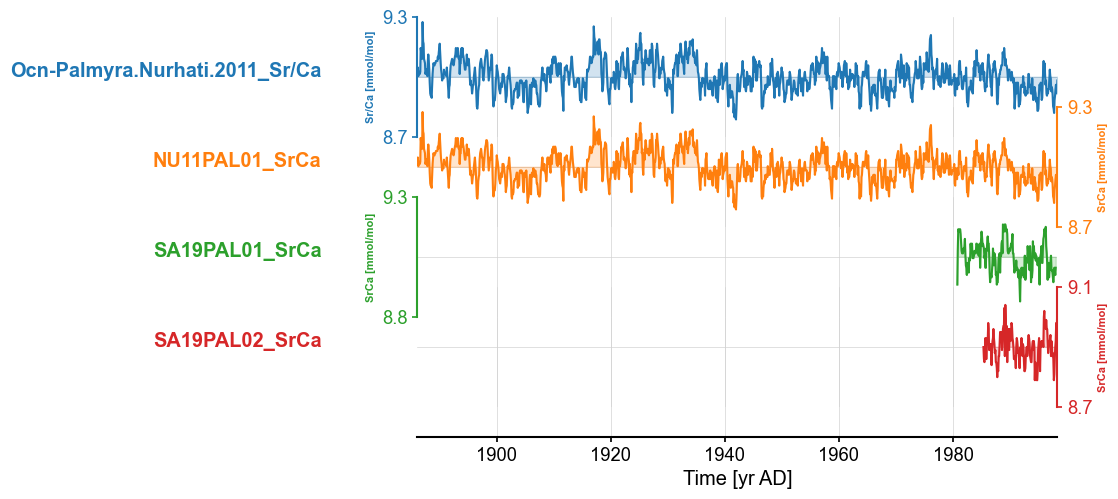

In [28]:
ts_list = []
for _, row in df_distance_SrCa.iterrows():
    proxy = row['paleoData_proxy'] if isinstance(row['paleoData_proxy'],str) else row['paleoData_variableName']
    ts_list.append(pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                            time_name='Time',value_name=row['paleoData_variableName'],
                            time_unit=row['time_units'], value_unit=row['paleoData_units'],
                            lat = row['geo_meanLat'], lon = row['geo_meanLon'], 
                            elevation = row['geo_meanElev'], importedFrom='lipdverse.org',
                            archiveType = row['archiveType'],
                            observationType=row['paleoData_proxy'],       
                            label=row['dataSetName']+'_'+proxy, verbose = False)) 

mgs_srca = pyleo.MultipleGeoSeries(ts_list) 
fig, ax = mgs_srca.stackplot()
fig.show()

The three records look very similar. The `Ocn-Palmyra.Nurhati.2011_Sr/Ca` and `NU11PAL01_SrCa` appear nearly identical. However, this may occur in other places in the database, so we want an algorithm to (1) find records that may be the same. We can follow a similar strategy as we have done here. a. Are they within 50km of each other and b. do they have the same or similar variable names, and (2) assess whether these records are, in fact, the same. 

We can do this in several ways: 
* Correlation: this may work well for true duplicates but may fail for composites
* Dynamic Time Warping (DTW), which can be used to to assess shape similarity even when time points aren’t exactly aligned. DTW returns a distance metric: lower values mean more similar patterns.It can be combined with a z-normalization to remove mean/variance effects.
* Principal Component Analysis (PCA)/ On groups of nearby records, run PCA to detect if certain records contribute nearly identical structure to the same components. High loadings on the same component can suggest redundancy.

Let's have a look at these three options.

###### Option 1: Correlation

Let's use the [Pyleoclim `correlation` function](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.correlation). The following code is inspired from [this tutorial](https://linked.earth/PyleoTutorials/notebooks/L2_correlations.html). 

In [29]:
n = len(mgs_srca.series_list)
corr_mat = np.empty((n,n))
corr_mat[:] = np.nan #let's only work on half of the matrix to speeds things up

for i in range(0, n-1): # loop over records 
    ts = mgs_srca.series_list[i]    
    mgsl = pyleo.MultipleGeoSeries(mgs_srca.series_list[i+1:]) #gather potential pairs
    corr = mgsl.correlation(ts,method='built-in') # compute correlations
    corr_mat[i,i+1:] = corr.r # save result in matrix

Looping over 3 Series in collection


100%|██████████| 3/3 [00:00<00:00, 193.66it/s]


Looping over 2 Series in collection


100%|██████████| 2/2 [00:00<00:00, 288.76it/s]


Looping over 1 Series in collection


100%|██████████| 1/1 [00:00<00:00, 336.57it/s]


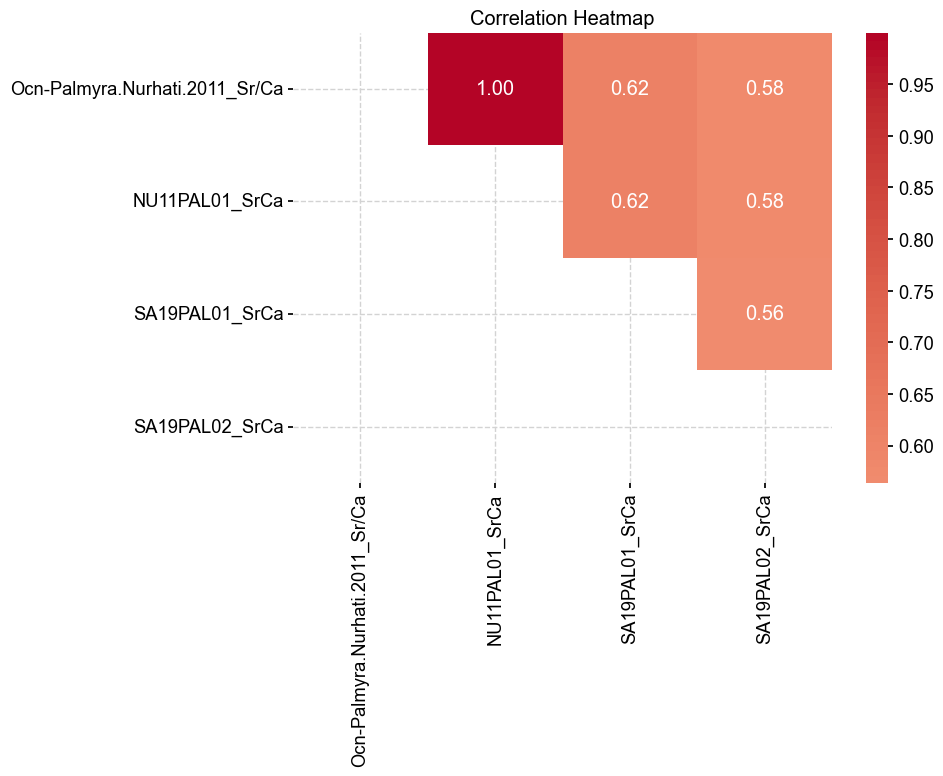

In [30]:
labels = []
for item in mgs_srca.series_list:
    labels.append(item.label)
core_matrix_df = pd.DataFrame(corr_mat, index=labels, columns=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(core_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Unsurprisingly, `Ocn-Palmyra.Nurhati.2011_Sr/Ca` and `NU11PAL01_SrCa` have a correlation of 1 as they are essentially the same record. The other correlations are below 0.8, which makes it difficult to assess whether they are, in fact the same record. Let's have a look at DTW as a potential discriminant.

###### Option 2: Dynamic Time Wrapping

Dynamic Time Wrapping (DTW) is a distance metric designed to compare time series that may be misaligned in time or differ in length. Unlike traditional correlation-based methods, DTW allows for flexible, non-linear alignment of sequences by warping the time axis to minimize the total distance between corresponding points. In our context, DTW provides a more robust measure of similarity between records than correlation, especially when records are composites or partially overlapping. By restricting comparisons to shared time intervals and z-score normalizing the data to emphasize shape similarity, DTW helps identify potentially redundant or duplicated records while accounting for the complexities inherent in paleoenvironmental data.

The following cell does the following:
* Clip the timeseries for similar time range for comparison
* Compute zscore
* Compute the DTW distance

In [31]:
# --- Helper function: clip to overlapping time range and normalize ---

def clip_to_overlap(time1, series1, time2, series2, min_overlap=5):
    start = max(time1[0], time2[0])
    end = min(time1[-1], time2[-1])
    
    mask1 = (time1 >= start) & (time1 <= end)
    mask2 = (time2 >= start) & (time2 <= end)

    if np.sum(mask1) < min_overlap or np.sum(mask2) < min_overlap:
        return None, None  # Not enough overlapping points
    
    return zscore(series1[mask1]), zscore(series2[mask2])

# --- Prepare the data ----
records = {}
times = {}

for series in mgs_srca.series_list:
    records[series.label] = series.value
    times[series.label] = series.time


# --- Main loop ---
labels = list(records.keys())
n = len(labels)
dtw_matrix = np.full((n, n), np.nan)

for i, j in itertools.combinations(range(n), 2):
    key_i, key_j = labels[i], labels[j]

    s1, s2 = clip_to_overlap(times[key_i], records[key_i],
                             times[key_j], records[key_j])

    if s1 is not None:
        path = dtw.warping_path(s1, s2)
        dist = dtw.distance(s1, s2)
        norm_dist = dist / len(path)  # Per-step normalization

        dtw_matrix[i, j] = dtw_matrix[j, i] = norm_dist

# Convert to DataFrame for visualization
dtw_df = pd.DataFrame(dtw_matrix, index=labels, columns=labels)

Let's visualize the results:

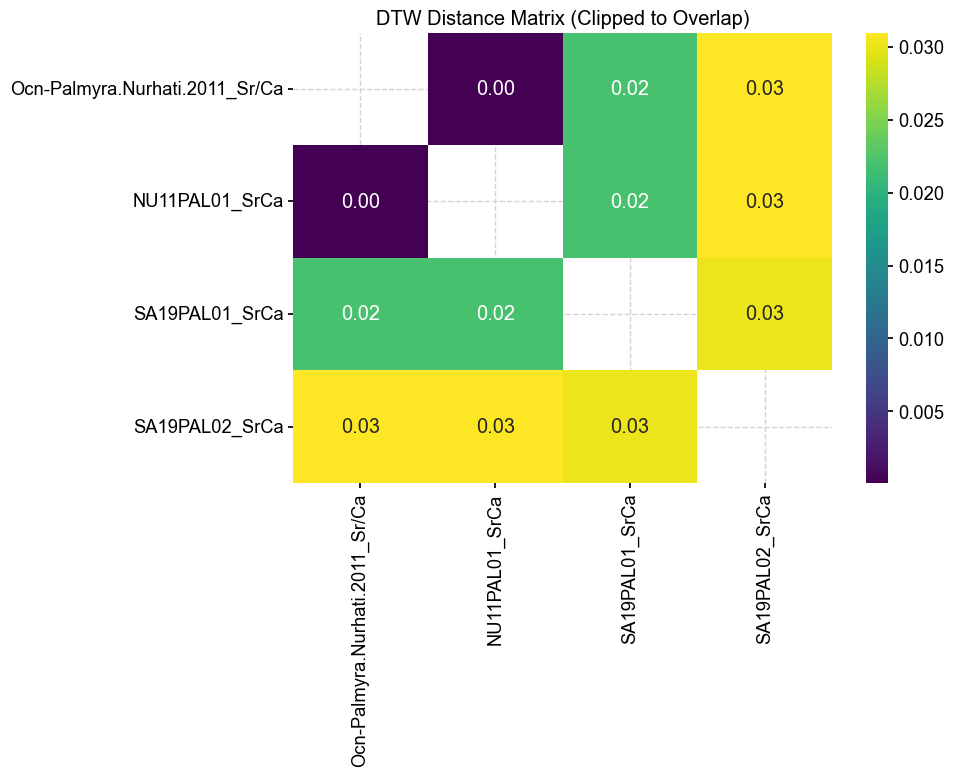

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(dtw_df, annot=True, fmt=".2f", cmap="viridis", mask=np.isnan(dtw_df))
plt.title("DTW Distance Matrix (Clipped to Overlap)")
plt.tight_layout()
plt.show()

The next problem lies in the interpretation of these results. The matrix holds pairwise DTW distances between time series. Each entry DTW[i, j] is a non-negative real number representing how similar two z-normalized time series are after optimal alignment.

* Lower values = more similar shape (after warping).
* Higher values = less similar (more misaligned or different structure).

Since we z-scored normalized the data and accounted for number of steps, the DTW distances can be interpreted as follows:

| Normalized DTW | Meaning                                                                 |
| -------------- | ----------------------------------------------------------------------- |
| **0.0 – 0.1**  | Very similar shape — likely same core or duplicated segment             |
| **0.1 – 0.2**  | High similarity — possibly same site, maybe overlapping or composited   |
| **0.2 – 0.4**  | Moderate similarity — same region, but different signal characteristics |
| **> 0.4**      | Different shape — likely independent records                            |


###### Option 3: Principal Component Analysis

Let's leverage the [PCA functionality in Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multiplegeoseries.MultipleGeoSeries.pca). A tutorial for this functionality is available [here](https://linked.earth/PyleoTutorials/notebooks/L2_principal_component_analysis.html). 

The first step is to brings the records on a common time axis and standardize them:

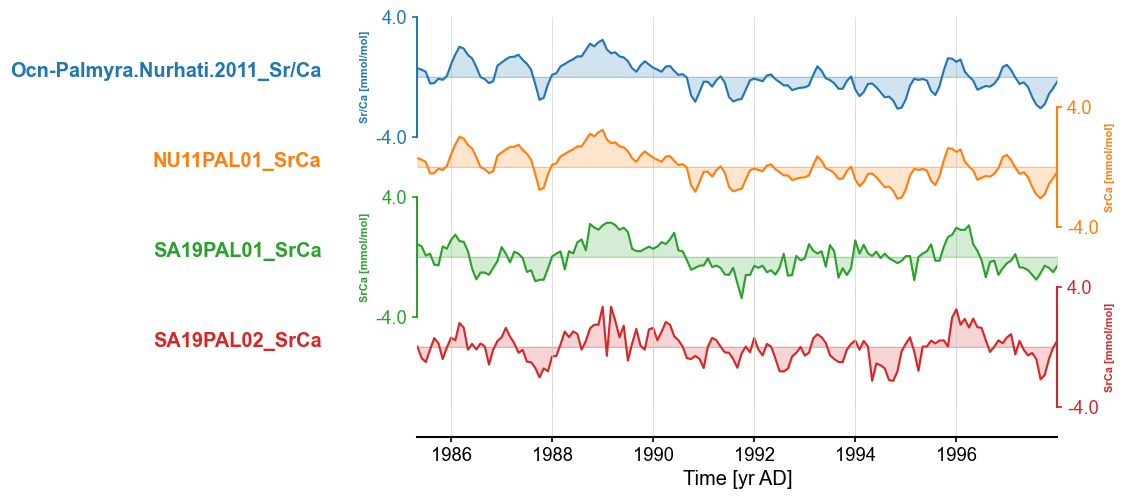

In [33]:
mgs_srca_sc = mgs_srca.common_time().standardize()
fig, ax = mgs_srca_sc.stackplot()

Let's run PCA:

In [34]:
pca = mgs_srca_sc.pca()

And let's have a look at the first mode:

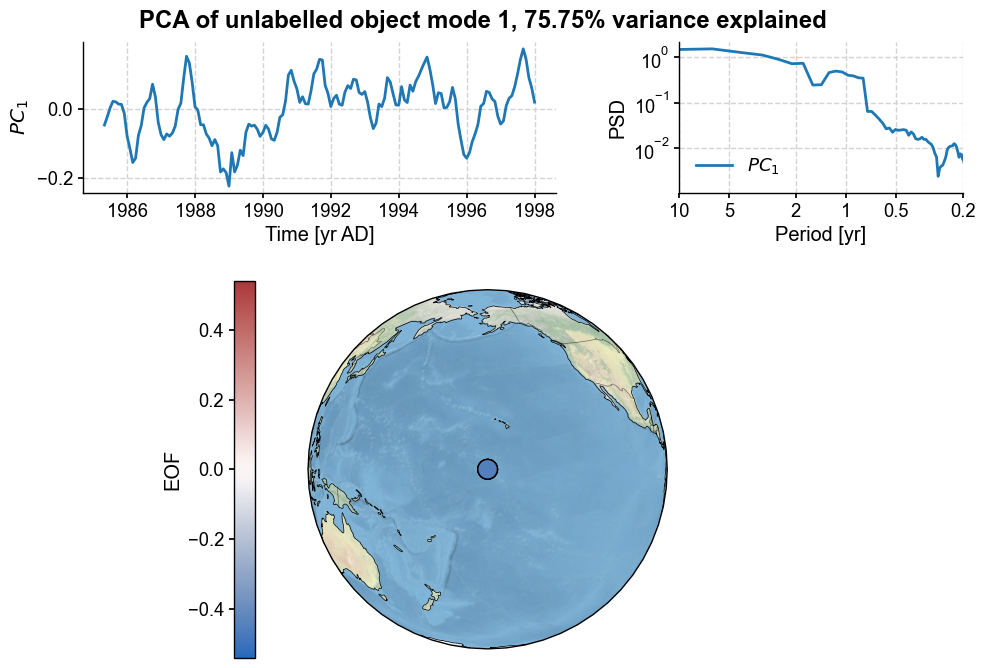

In [35]:
fig, ax = pca.modeplot()

Not unsurprisingly, the first PC explains over 75% of the variance. Let's have a look at the loads:

In [36]:
pca.eigvecs[1]

array([-0.54194915,  0.4525358 ,  0.03876175, -0.70710678])

The loads are not very similar, which is interesting considering that tow of these records are definitely the same. PCA may not work well to find duplicates.

**Based on this small proof of concept, correlation and DTW seems to be a reasonable approach to identify duplicates in the database.**

##### Handling duplication part 2: $\delta^{18}\mathrm{O}$
Let's now have a look at the various $\delta^{18}\mathrm{O}$ records. 

In [37]:
df_distance_d18O = df_distance[df_distance['paleoData_variableName']=='d18O']
df_distance_d18O.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,...,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units,distance_km
1,Ocn-Palmyra.Cobb.2013,Pages2kTemperature,Coral,5.870,-162.130,-7.0,d18O,d18O,"[-4.651, -4.631, -4.629, -4.562, -4.58, -4.442...",permil,...,None,subannual,temperature,NaN,Ocean2kHR_139,year,year,"[928.125, 928.209, 928.292, 928.375, 928.459, ...",yr AD,1.176328
2,CO03COPM,iso2k,Coral,5.870,-162.130,-7.0,d18O,d18O,"[-5.27, -5.42, -5.49, -5.5, -5.44, -5.48, -5.5...",permil,...,None,subannual,temperature,NaN,Ocean2kHR_139_iso2k,year,year,"[1998.37, 1998.29, 1998.2, 1998.13, 1998.04, 1...",yr AD,1.176328
3,NU11PAL01,CoralHydro2k,Coral,5.867,-162.133,-9.0,d18O,d18O,"[-4.79, -4.89, -4.81, -4.84, -4.85, -4.82, -4....",permil,...,None,None,None,NaN,NU11PAL01_d18O,year,year,"[1886.13, 1886.21, 1886.29, 1886.38, 1886.46, ...",yr AD,1.439510
5,SA19PAL01,CoralHydro2k,Coral,5.878,-162.142,-10.0,d18O,d18O,"[-5.21, -5.23, -5.17, -5.13, -5.11, -5.05, -5....",permil,...,None,None,None,NaN,SA19PAL01_d18O,year,year,"[1983.58, 1983.67, 1983.75, 1983.83, 1983.92, ...",yr AD,2.754166
7,SA19PAL02,CoralHydro2k,Coral,5.878,-162.142,-10.0,d18O,d18O,"[-5.05, -5.1, -5.21, -5.14, -5.23, -5.32, -5.3...",permil,...,None,None,None,NaN,SA19PAL02_d18O,year,year,"[1985.92, 1986.0, 1986.08, 1986.17, 1986.25, 1...",yr AD,2.754166


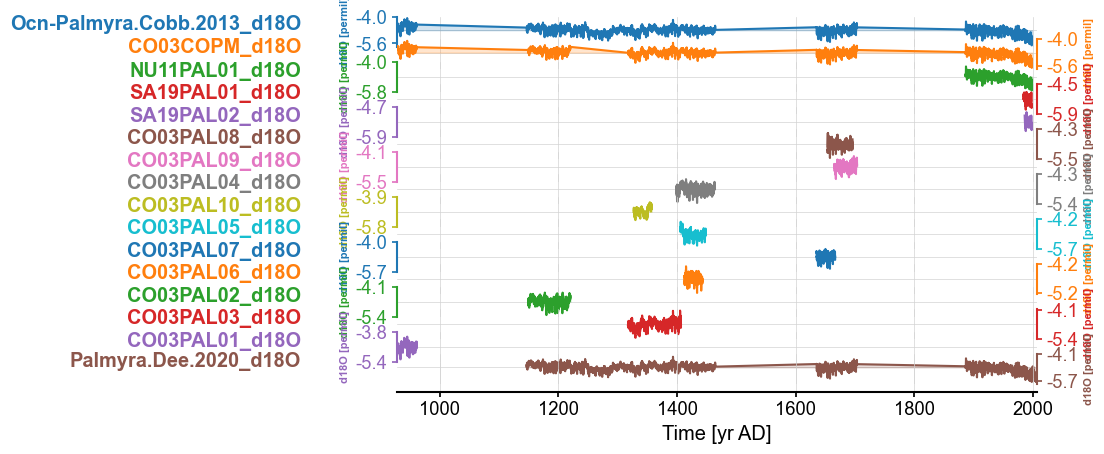

In [38]:
ts_list = []
for _, row in df_distance_d18O.iterrows():
    proxy = row['paleoData_proxy'] if isinstance(row['paleoData_proxy'],str) else row['paleoData_variableName']
    ts_list.append(pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                            time_name='Time',value_name=row['paleoData_variableName'],
                            time_unit=row['time_units'], value_unit=row['paleoData_units'],
                            lat = row['geo_meanLat'], lon = row['geo_meanLon'], 
                            elevation = row['geo_meanElev'], importedFrom='lipdverse.org',
                            archiveType = row['archiveType'],
                            observationType=row['paleoData_proxy'],       
                            label=row['dataSetName']+'_'+proxy, verbose = False)) 

# Add the Dee et al. record

ts_list.append(pyleo.GeoSeries(time=df_palm_filt['time_values'].iloc[0],
                    value=df_palm_filt['paleoData_values'].iloc[0],
                    time_name='Time',
                    value_name=df_palm_filt['paleoData_variableName'].iloc[0],
                    time_unit=df_palm_filt['time_units'].iloc[0], 
                    value_unit=df_palm_filt['paleoData_units'].iloc[0],
                    lat = df_palm_filt['geo_meanLat'].iloc[0],
                    lon = df_palm_filt['geo_meanLon'].iloc[0], 
                    elevation = df_palm_filt['geo_meanElev'].iloc[0],
                    importedFrom='lipdverse.org',
                    archiveType = df_palm_filt['archiveType'].iloc[0],
                    observationType=df_palm_filt['paleoData_proxy'].iloc[0],       
                    label=df_palm_filt['dataSetName'].iloc[0]+'_'+proxy, verbose = False))

mgs = pyleo.MultipleGeoSeries(ts_list) 
fig, ax = mgs.stackplot()

As we have seen with the Sr/Ca record, there seems to be duplications among the record. Although some look like changes in the age models. Let's explore correlation and DTW to weed out the duplicates.

###### Option 1: Correlation

In [39]:
n = len(mgs.series_list)
corr_mat = np.empty((n,n))
corr_mat[:] = np.nan #let's only work on half of the matrix to speeds things up

for i in range(0, n-1): # loop over records 
    ts = mgs.series_list[i]    
    mgsl = pyleo.MultipleGeoSeries(mgs.series_list[i+1:]) #gather potential pairs
    corr = mgsl.correlation(ts,method='built-in') # compute correlations
    corr_mat[i,i+1:] = corr.r # save result in matrix

Looping over 15 Series in collection


100%|██████████| 15/15 [00:00<00:00, 543.36it/s]


Looping over 14 Series in collection


100%|██████████| 14/14 [00:00<00:00, 612.66it/s]


Looping over 13 Series in collection


100%|██████████| 13/13 [00:00<00:00, 2594.87it/s]


Looping over 12 Series in collection


100%|██████████| 12/12 [00:00<00:00, 3536.76it/s]


Looping over 11 Series in collection


100%|██████████| 11/11 [00:00<00:00, 3804.83it/s]


Looping over 10 Series in collection


100%|██████████| 10/10 [00:00<00:00, 2108.33it/s]


Looping over 9 Series in collection


100%|██████████| 9/9 [00:00<00:00, 1791.42it/s]


Looping over 8 Series in collection


100%|██████████| 8/8 [00:00<00:00, 501.88it/s]


Looping over 7 Series in collection


100%|██████████| 7/7 [00:00<00:00, 980.70it/s]


Looping over 6 Series in collection


100%|██████████| 6/6 [00:00<00:00, 1411.43it/s]


Looping over 5 Series in collection


100%|██████████| 5/5 [00:00<00:00, 2103.25it/s]


Looping over 4 Series in collection


100%|██████████| 4/4 [00:00<00:00, 1598.13it/s]


Looping over 3 Series in collection


100%|██████████| 3/3 [00:00<00:00, 1029.53it/s]


Looping over 2 Series in collection


100%|██████████| 2/2 [00:00<00:00, 651.24it/s]


Looping over 1 Series in collection


100%|██████████| 1/1 [00:00<00:00, 21290.88it/s]


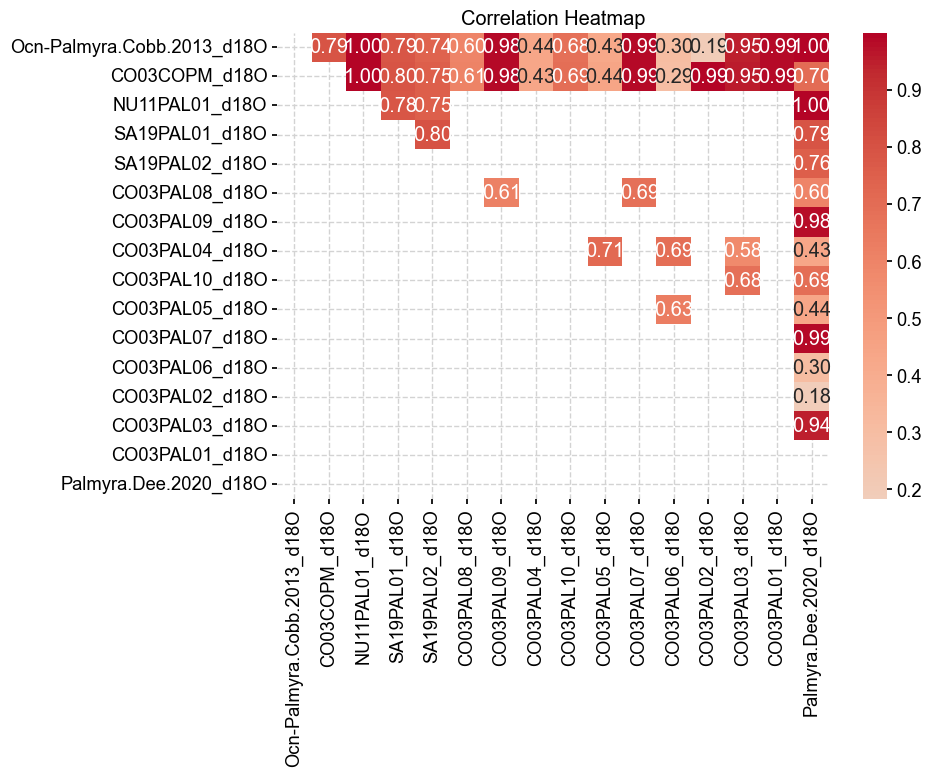

In [40]:
labels = []
for item in mgs.series_list:
    labels.append(item.label)
core_matrix_df = pd.DataFrame(corr_mat, index=labels, columns=labels)
plt.figure(figsize=(10, 8))
sns.heatmap(core_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Some of the correlations are high, suggesting that the small segments went into the composited records. Note that some of the correlations were not run since the segments were not overlapping and were, therefore, skipped. 

###### Option 2: DTW

Let's look at the DTW method to identify duplicates.

In [41]:
# --- Prepare the data ----
records = {}
times = {}

for series in mgs.series_list:
    records[series.label] = series.value
    times[series.label] = series.time


# --- Main loop ---
labels = list(records.keys())
n = len(labels)
dtw_matrix = np.full((n, n), np.nan)

for i, j in itertools.combinations(range(n), 2):
    key_i, key_j = labels[i], labels[j]

    s1, s2 = clip_to_overlap(times[key_i], records[key_i],
                             times[key_j], records[key_j])

    if s1 is not None:
        path = dtw.warping_path(s1, s2)
        dist = dtw.distance(s1, s2)
        norm_dist = dist / len(path)  # Per-step normalization

        dtw_matrix[i, j] = dtw_matrix[j, i] = norm_dist

# Convert to DataFrame for visualization
dtw_df = pd.DataFrame(dtw_matrix, index=labels, columns=labels)

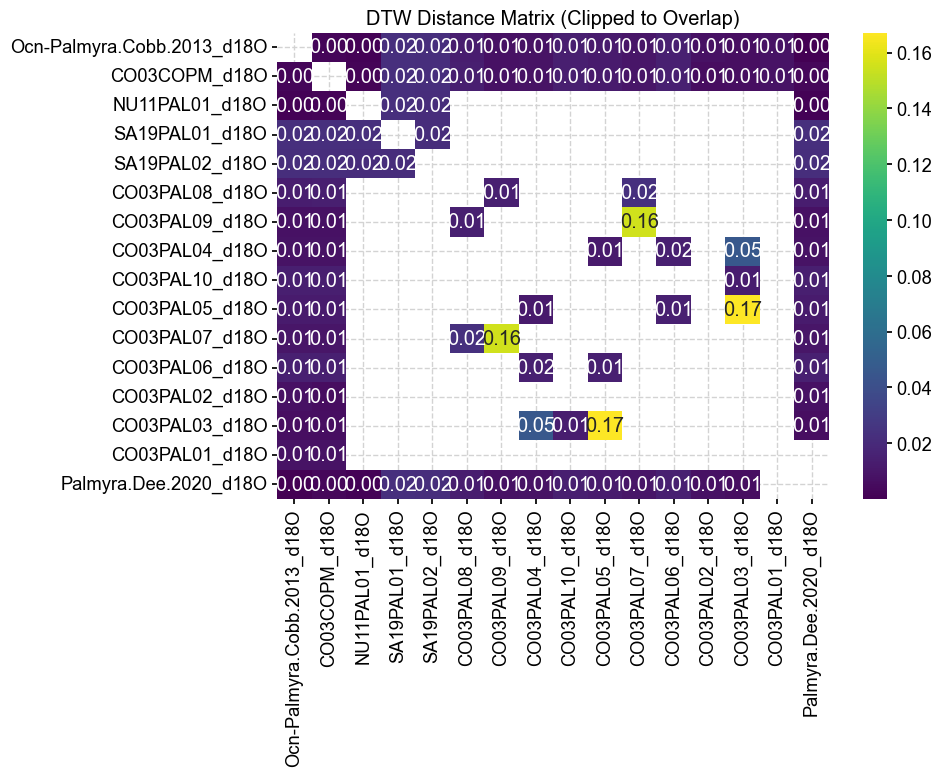

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(dtw_df, annot=True, fmt=".2f", cmap="viridis", mask=np.isnan(dtw_df))
plt.title("DTW Distance Matrix (Clipped to Overlap)")
plt.tight_layout()
plt.show()

The DTW method largely confirms what we have seen from the correlations in terms of duplicates. However, note that the DTW method indicates that the records from `OCN-Palmyra.Cobb.2013` and `CO03COPM` have a correlation of 0.79 but a DTW of 0. The DTW would essentially indicate that they are in fact the same records but the correlation is less than 0.8. This is due to the interpolation needed to calculate correlation over the 14th century, highlighting the need to run DTW for records with larger gaps. We will use the insights gained here to clean the database in the next section of this notebook. For now, let's add the Dee et al. (2020) record to the database:

In [43]:
df_raw = pd.concat([df_raw, df_palm_filt], ignore_index=True)
df_raw.tail()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,...,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units,distance_km
968,ZI08MAY01,CoralHydro2k,Coral,-12.6500,45.10,-2.0,SrCa,Sr/Ca,"[8.947578, 8.797017, 8.784511, 8.751525, 8.778...",mmol/mol,...,None,None,None,NaN,ZI08MAY01_SrCa,year,year,"[1881.6247, 1881.791367, 1881.958033, 1882.124...",yr AD,16936.585327
969,LI06FIJ01,CoralHydro2k,Coral,-16.8200,179.23,-10.0,d18O,d18O,"[-4.6922, -4.6266, -4.6018, -4.5486, -4.6102, ...",permil,...,None,None,None,NaN,LI06FIJ01_d18O,year,year,"[1617.5, 1618.5, 1619.5, 1620.5, 1621.5, 1622....",yr AD,3250.716202
970,SM06LKF02,CoralHydro2k,Coral,24.5600,-81.41,-4.0,d18O,d18O,"[-3.85, -3.98, -4.21, -4.06, -3.97, -4.04, -3....",permil,...,None,None,None,NaN,SM06LKF02_d18O,year,year,"[1960.97, 1961.03, 1961.09, 1961.15, 1961.21, ...",yr AD,8799.120973
971,SM06LKF02,CoralHydro2k,Coral,24.5600,-81.41,-4.0,SrCa,Sr/Ca,"[9.225, nan, 9.195, 9.221, 9.198, 9.281, 9.319...",mmol/mol,...,None,None,None,NaN,SM06LKF02_SrCa,year,year,"[1960.97, 1961.03, 1961.09, 1961.15, 1961.21, ...",yr AD,8799.120973
972,Palmyra.Dee.2020,None,Coral,5.8664,-162.12,-9.0,d18O,d18O,"[-4.749, -4.672, -4.724, -4.717, -4.8947, -4.8...",permil,...,isotopic,subannual,temperature,NaN,PCU-1cce3af5639a4ec,year,year,"[1146.375, 1146.4583, 1146.5417, 1146.625, 114...",yr AD,NaN


Let's drop the added columns that we put in for distance:

In [44]:
df_raw = df_raw.drop(columns=['distance_km'])

## Data Cleaning and Pre-processing

This section deals with cleaning and pre-processing for use with the [`cfr` codebase](https://fzhu2e.github.io/cfr/). We will do so in three steps:

* Step 1: Remove records that are less than 150 years. For reconstruction purposes, we need series that go back at least to 1850; many in this database do not, so we remove them to avoid disappointments later on.
* Step 2: Remove duplicates. We will use an algorithm based on the data exploratory analysis we did for the specific case of the Palmyra record and generalize it. 
* Step 3: Filtering for records with annual to subannual resolution. 

### Step 1: Remove records shorter than 150 years

For reconstruction purposes, we need series that go back at least to 1850; many in this database do not, so we remove them to avoid disappointments later on. Let's first look at the start date of these records.

In [45]:
df_raw['min_time'] = df_raw['time_values'].apply(lambda x: min(x) if isinstance(x, list) and x else float('inf'))
filtered_df = df_raw[df_raw['min_time'] < 1850]
filtered_df = filtered_df.drop(columns=['min_time'])
print(filtered_df.shape)

(744, 20)


That leaves us with 744 timeseries.

### Step 2: Screen for duplicates

Based on the preliminary work we have done with the Palmyra records, we will used the following algorithm to identify duplicates:

1. Look for records within 10km of each other
2. Look at whether the variable name is the same
3. Calculate correlations among the records
4. Calculate the DTW distance among the records.
5. For correlations >0.8 OR DTW distance < 0.03, use the following:

    a. Use the latest publication date (based on dataset name)
    
    b. Use the longest record if the publication date is the same

Let's have a look at the variable names present in the database to see if there are synonyms we have to deal with. Let's make sure that we use a criteria that doesn't have any missing values:


In [46]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 0 to 972
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dataSetName             744 non-null    object 
 1   compilationName         743 non-null    object 
 2   archiveType             744 non-null    object 
 3   geo_meanLat             744 non-null    float64
 4   geo_meanLon             744 non-null    float64
 5   geo_meanElev            737 non-null    object 
 6   paleoData_variableName  744 non-null    object 
 7   paleoData_standardName  744 non-null    object 
 8   paleoData_values        744 non-null    object 
 9   paleoData_units         336 non-null    object 
 10  paleoData_proxy         665 non-null    object 
 11  paleoData_proxyGeneral  501 non-null    object 
 12  paleoData_seasonality   659 non-null    object 
 13  paleoData_interpName    665 non-null    object 
 14  paleoData_interpRank    12 non-null     float64

From this, it seems that `paleoData_standardName` could work for our purposes since there are no missing values in this field and most of the names should have been standardized:

In [47]:
filtered_df['paleoData_standardName'].unique()

array(['d18O', 'MXD', 'density', 'ringWidth', 'temperature',
       'reflectance', 'Sr/Ca', 'iceMelt', 'd2H', 'thickness',
       'RABD660670', 'calcificationRate', 'varveThickness', 'MAR'],
      dtype=object)

The names are unique. Let's proceed with the main loop. But first, let's define some constants and parameters for the algorithm described above:

In [48]:
# --- Define some parameters ---
threshold  = 10 # Distance in km
corr_threshold = 0.8 # Corr threshold over which two records are considered the same. 
dtw_threshold = 0.03 # DTW threshold under which two records are considered the same. 

Let's also consider writing some functions to calculate the various criteria described above:
1. Distance on aa sphere using the Haversine distance
2. Correlation among multiple timeseries using Pyleoclim
3. DTW amon multiple timeseries

In [49]:
# --- Haversine distance function in km ---
def haversine(lat1, lon1, lats2, lons2, R=6371):
    """Calculate the haversine distance between a target location and a vector of locations. 

    Args:
        lat1 (float): The target latitude
        lon1 (float): the target longitude
        lats2 (np.array or df.Series): The latitude of the locations to check against
        lons2 (np.array or df.Series): The longitude of the locations to check against
        R (int, optional): The radius of the planet in km. Defaults to 6371 for Earth.

    Returns:
        np.array: The distance between the target location and the vector of locations in km.
    """
    # Convert degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lats2 = np.radians(lats2)
    lons2 = np.radians(lons2)

    # Haversine formula
    dlat = lats2 - lat1
    dlon = lons2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lats2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R*c


# ----- Correlation function ------

def correlation(data):
    """Calculate correlation among multiple timeseries

    Parameters
    ----------
    data: pd.DataFrame
        A pandas DataFrame containing the necessary information to create Pyleoclim.GeoSeries() objects
    
    Returns
    -------
    A DataFrame containing pairwise correlations
    """
    ds_name1 = [] # list of dataset names used as correlation basis
    ds_name2 = [] # list of dataset names used as the series to correlate against
    # Same for tsids since they are unique and we can find them again easily in the database
    tsid1 = []
    tsid2 = []
    # list to keep the correlations
    corr = []

    # Create a MultipleGeoSeries object

    ts_list = []

    for idx, row in data.iterrows():

        ts = pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                            time_name='Time',value_name=row['paleoData_standardName'],
                            time_unit=row['time_units'], value_unit=row['paleoData_units'],
                            lat = row['geo_meanLat'], lon = row['geo_meanLon'], 
                            elevation = row['geo_meanElev'], archiveType = row['archiveType'],    
                            label=row['TSID']+'+'+row['dataSetName'], verbose = False)
        ts_list.append(ts)

    for i,j in itertools.combinations(range(len(ts_list)), 2):
        ts1 = ts_list[i] #grab the first timeseries
        ts2 = ts_list[j]

        # append the names and tsids
        ds_name1.append(ts1.label.split('+')[1])
        tsid1.append(ts1.label.split('+')[0])
                
        ds_name2.append(ts2.label.split('+')[1])
        tsid2.append(ts2.label.split('+')[0])

        # calculate the correlation
        corr_res = ts1.correlation(ts2, method = 'built-in')

        # Store the information
        corr.append(corr_res.r)
    
    # Step 3: Summarize results

    return pd.DataFrame({'dataSetName1': ds_name1,
                         'dataSetName2': ds_name2,
                         'TSID1': tsid1,
                         'TSID2': tsid2,
                        'correlation': corr}) 


# ------ DTW function


def dtw_pair(data):
    """Calculates the DTW betwen the records in the dataframe

    Args:
        data (pd.DataFrame): A pandas DataFrame containing the necessary information to create Pyleoclim.GeoSeries() objects

    Returns:
        pd.DataFrame: A DataFrame containing pairwise DTW
    """

    ### Helper function
    
    def clip_to_overlap(time1, series1, time2, series2, min_overlap=5):
        """Helper function to clip the series to common overlap. Note we do  not need to interpolate for DTW, just make sure that the time is overlapping

        Args:
            time1 (np.array): Time vector for Series 1
            series1 (np.array): Value vector for Series 1
            time2 (np.array): Time vector for Series 2
            series2 (np.array): Value vector for Series 2
            min_overlap (int, optional): Minimum number of pointe to even attempt the computation. Defaults to 5.

        Returns:
            np.array, np.array: The zscore of the values for the time of overlap.  
        """
        # Make sure things are sorted and have no NaNs
        valid1 = (~np.isnan(time1)) & (~np.isnan(series1))
        time1 = time1[valid1]
        series1 = series1[valid1]

        valid2 = (~np.isnan(time2)) & (~np.isnan(series2))
        time2 = time2[valid2]
        series2 = series2[valid2]

        # Return early if either series is now empty
        if len(time1) == 0 or len(time2) == 0:
            return None, None


        sort_idx1 = np.argsort(time1)
        time1_sorted = time1[sort_idx1]
        series1_sorted = series1[sort_idx1]

        sort_idx2 = np.argsort(time2)
        time2_sorted = time2[sort_idx2]
        series2_sorted = series2[sort_idx2]

        # Determine overlapping interval
        start = max(time1_sorted[0], time2_sorted[0])
        end = min(time1_sorted[-1], time2_sorted[-1])

        # Apply mask
        mask1 = (time1_sorted >= start) & (time1_sorted <= end)
        mask2 = (time2_sorted >= start) & (time2_sorted <= end)

        if np.sum(mask1) < min_overlap or np.sum(mask2) < min_overlap:
            return None, None # Not enough overlapping points

        clipped1 = series1_sorted[mask1]
        clipped2 = series2_sorted[mask2]

        # Avoid division by zero if std = 0
        if np.std(clipped1) == 0 or np.std(clipped2) == 0:
            return None, None

        return zscore(clipped1), zscore(clipped2)
   
    ### Main function 

    ds_name1 = [] # list of dataset names used as correlation basis
    ds_name2 = [] # list of dataset names used as the series to correlate against
    # Same for tsids since they are unique and we can find them again easily in the database
    tsid1 = []
    tsid2 = []
    # list to keep the DTW
    dtw_list = []

    for idx1, idx2 in itertools.combinations(data.index, 2):
        row1 = data.loc[idx1] #grab the first record
        row2 = data.loc[idx2] #grab the second record

        ds_name1.append(row1['dataSetName'])
        ds_name2.append(row2['dataSetName'])
        tsid1.append(row1['TSID'])
        tsid2.append(row2['TSID'])

        s1, s2 = clip_to_overlap(np.array(row1['time_values']), np.array(row1['paleoData_values']),
                                 np.array(row2['time_values']), np.array(row2['paleoData_values']))
        

        if s1 is not None:
            path = dtw.warping_path(s1, s2)
            dist = dtw.distance(s1, s2)
            dtw_list.append(dist / len(path))  # Per-step normalization
        else:
            dtw_list.append(np.nan)

    df= pd.DataFrame({'dataSetName1': ds_name1,
                       'dataSetName2': ds_name2,
                       'TSID1': tsid1,
                       'TSID2': tsid2,
                       'dtw': dtw_list})
        
    return df
    

In [50]:
df_list = [] # Containers for the list of DataFrames with spurious correlations
tsids = [] #to keep track of the tsids that have already been checked against the distance criteria

#make a copy of the dataframe as we need to modify it for this loop
df_copy = filtered_df.copy()

for idx, row in df_copy.iterrows():

    # Check that we haven't already looked at the record in the context of another distance search

    if row['TSID'] in tsids:
        continue #go to the next row

    # ---- Criteria 1: Distance -----
    # Target location
    lat1, lon1 = row['geo_meanLat'], row['geo_meanLon']
    distance_km = haversine(lat1,lon1,df_copy['geo_meanLat'],df_copy['geo_meanLon'])

    # Add distance column
    df_copy['distance_km'] = distance_km

    # Filter to only rows within a threshold
    df_distance = df_copy[df_copy['distance_km'] <= threshold].reset_index(drop=True)

    # Store the TSIDs so we don't run this multiple times
    tsids.extend(df_distance['TSID'].to_list())

    # If there is only one entry (the original one, go to the next row)
    if len(df_distance)<=1:
        continue

    # ---- Criteria 2: Variable Name ------

    var_unique = df_distance['paleoData_standardName'].unique()

    for var in var_unique:
        df_var_filt = df_distance[df_distance['paleoData_standardName'] == var].reset_index(drop=True)
        
        if len(df_var_filt) >1:

    # ----- Criteria 3: Correlation -------
            corr_df = correlation(df_var_filt)
    
    # ------ Criteria 4: DTW --------
            dtw_df = dtw_pair(df_var_filt)
        
            #put the results together
            common_cols = ['dataSetName1', 'dataSetName1', 'TSID1','TSID2']

            df_combined = pd.merge(corr_df, dtw_df, on=common_cols)
            df_res = df_combined[(df_combined['correlation'] > corr_threshold) | (df_combined['dtw'] < dtw_threshold)]

            if not df_res.empty:
                df_list.append(df_res)

Let's see how many similar records we have:

In [51]:
len(df_list)

89

Let's have a look at each records with duplicated and create a log (human in the loop) of why records were removed from the database. 


⚠️ **Warning** 

The following cell produces a widget that allows you to go through each of the similar records and to keep/remove records. If you do so, you will change the nature of the database. 

<div style="border-left: 6px solid #e74c3c; background-color: #f8d7da; padding: 10px; margin: 10px 0;">
  <strong>❗ DO NOT RUN THIS CELL UNLESS YOU WANT TO CLEAN THE DATABASE YOURSELF. NOT RECOMMENDED!!!!!! Skip to the last section to load the cleaned database directly. 
</div>


In [ ]:
from IPython.display import display, clear_output, Markdown
import ipywidgets as widgets

# Storage
flagged_records = []
group_notes = []

df_copy = filtered_df.copy()
index_tracker = {'i': 0}

def run_iteration(i):
    clear_output(wait=True)

    # Final screen
    if i >= len(df_list):
        print("✅ Review complete!")

        if flagged_records:
            print("\n🚩 Flagged TSIDs:")
            display(pd.DataFrame(flagged_records))
        else:
            print("\n🚩 No TSIDs were flagged.")

        if group_notes and any(n['Note'].strip() for n in group_notes):
            print("\n📝 Notes from each group:")
            markdown_notes = "\n\n".join(
                [
                    f"### Iteration {note['Group'] + 1}\n"
                    f"```\n{note['Note']}\n```"
                    for note in group_notes if note['Note'].strip()
                ]
            )
            display(Markdown(markdown_notes))
        else:
            print("\n📝 No group notes were entered.")

        # Final Done button
        done_button = widgets.Button(description="Done", button_style='success')

        def on_done_clicked(b):
            clear_output(wait=True)
            print("🎉 Done! You may now export your results.")

        done_button.on_click(on_done_clicked)
        display(done_button)
        return

    # Begin reviewing group i
    df = df_list[i]
    print(f"--- Reviewing DataFrame {i+1}/{len(df_list)} ---")

    valid_ids = pd.concat([df['TSID1'], df['TSID2']]).unique()
    df_lookup = df_copy[df_copy['TSID'].isin(valid_ids)]
    display(df_lookup)

    # Plot time series
    ts_list = []
    for _, row in df_lookup.iterrows():
        ts = pyleo.GeoSeries(
            time=row['time_values'],
            value=row['paleoData_values'],
            time_name='Time',
            value_name=row['paleoData_standardName'],
            time_unit=row['time_units'],
            value_unit=row['paleoData_units'],
            lat=row['geo_meanLat'],
            lon=row['geo_meanLon'],
            elevation=row['geo_meanElev'],
            archiveType=row['archiveType'],
            label=row['TSID'] + '+' + row['dataSetName'],
            verbose=False
        )
        ts_list.append(ts)

    if ts_list:
        mgs = pyleo.MultipleGeoSeries(ts_list)
        fig, ax = mgs.stackplot()
        fig.show()
    else:
        print("No valid time series to plot.")

    # Create widgets for TSIDs
    tsid_widgets = []
    for tsid in valid_ids:
        toggle = widgets.RadioButtons(
            options=['Keep', 'Remove'],
            value='Keep',
            description=f'{tsid}:',
            layout=widgets.Layout(width='40%')
        )
        tsid_widgets.append((tsid, toggle))

    toggle_box = widgets.VBox([w[1] for w in tsid_widgets])

    # Shared note box (pre-filled)
    note_template = "Records from different samples. Not true duplicates."
    note_box = widgets.Textarea(
        value=note_template,
        layout=widgets.Layout(width='100%', height='60px')
    )

    # Buttons
    next_button = widgets.Button(description="Next", button_style='success')
    back_button = widgets.Button(description="Back", button_style='warning')
    quit_button = widgets.Button(description="Quit", button_style='danger')
    button_box = widgets.HBox([next_button, back_button, quit_button])

    # --- Button callbacks ---
    def on_next_clicked(b):
        note = note_box.value.strip()

        # Remove prior flags and note for this group
        group_notes[:] = [n for n in group_notes if n['Group'] != i]
        flagged_records[:] = [r for r in flagged_records if r['TSID'] not in valid_ids]

        # Save new notes and flags
        group_notes.append({'Group': i, 'Note': note})
        for tsid, toggle in tsid_widgets:
            if toggle.value == 'Remove':
                flagged_records.append({'TSID': tsid, 'Note': note})

        index_tracker['i'] += 1
        run_iteration(index_tracker['i'])

    def on_back_clicked(b):
        if index_tracker['i'] > 0:
            index_tracker['i'] -= 1
            run_iteration(index_tracker['i'])
        else:
            print("You're already at the first group.")

    def on_quit_clicked(b):
        clear_output(wait=True)
        print("⚠️ Quit early.")

        if flagged_records:
            print("\n🚩 Flagged TSIDs:")
            display(pd.DataFrame(flagged_records))

        if group_notes and any(n['Note'].strip() for n in group_notes):
            print("\n📝 Notes from each group:")
            markdown_notes = "\n\n".join(
                [
                    f"### Iteration {note['Group'] + 1}\n"
                    f"```\n{note['Note']}\n```"
                    for note in group_notes if note['Note'].strip()
                ]
            )
            display(Markdown(markdown_notes))
        else:
            print("\n📝 No group notes were entered.")

    # Hook up buttons
    next_button.on_click(on_next_clicked)
    back_button.on_click(on_back_clicked)
    quit_button.on_click(on_quit_clicked)

    # Display UI
    display(button_box, toggle_box, note_box)

# Start the interactive loop
run_iteration(index_tracker['i'])


,TSID,Note
0,Ocean2kHR_142_iso2k,Ocean2kHR_142_iso2k is a duplicate of Ocean2kH...
1,Ocean2kHR_156_iso2k,Ocean2kHR_142_iso2k is a duplicate of Ocean2kH...
2,Ocean2kHR_157_iso2k,Ocean2kHR_142_iso2k is a duplicate of Ocean2kH...
3,LI00RAR01_d18O,Same records. Keeping 147.
4,LI00RAR01_SrCa,Same record. Keeping 149
5,Ocean2kHR_006_iso2k,"Same records, keeping Ocean2kHR_006 from PAGES2k"
6,CH03LOM01_d18O,"Same records, keeping Ocean2kHR_006 from PAGES2k"
7,Ocean2kHR_019_iso2k,Same record. Keeping Ocean2kHR_019
8,FE18RUS01_d18O,Same record. Keeping Ocean2kHR_019
9,CA07FLI01_SrCa,Records from different samples. Not true dupli...


### Iteration 1
```
Records from different samples. Not true duplicates.
```

### Iteration 2
```
Records from different samples. Not true duplicates.
```

### Iteration 3
```
Records from different samples. Not true duplicates.
```

### Iteration 4
```
Records from different samples. Not true duplicates.
```

### Iteration 5
```
Records from different samples. Not true duplicates.
```

### Iteration 6
```
Records from different samples. Not true duplicates.
```

### Iteration 7
```
Records from different samples. Not true duplicates.
```

### Iteration 8
```
Records from different samples. Not true duplicates.
```

### Iteration 9
```
Ocean2kHR_142_iso2k is a duplicate of Ocean2kHR_142 deom most likely PAGES2k. Removing iso2k record. Same with 156 and 157
```

### Iteration 10
```
From publications info in GraphDB. Different records.
```

### Iteration 11
```
Same records. Keeping 147.
```

### Iteration 12
```
Same record. Keeping 149
```

### Iteration 13
```
Same records, keeping Ocean2kHR_006 from PAGES2k
```

### Iteration 14
```
Same record. Keeping Ocean2kHR_019
```

### Iteration 15
```
Records from different samples. Not true duplicates.
```

### Iteration 16
```
Records from different samples. Not true duplicates.
```

### Iteration 17
```
Same record. Keeping Ocean2kHR_193
```

### Iteration 18
```
Two records but duplicates. Keeping Ocean2kHR_023 and 026.
```

### Iteration 19
```
Two records. Keeping Ocean2kHR 027 and 025
```

### Iteration 20
```
Same record across all compilations. Keeping Ocean2kHR_133
```

### Iteration 21
```
Records from different samples. Not true duplicates.
```

### Iteration 22
```
Same record across all three compilations. Keeping Ocean2kHR_183
```

### Iteration 23
```
Same record across all three compilations. Keeping Ocean2kHR166
```

### Iteration 24
```
Records from different samples. Not true duplicates.
```

### Iteration 25
```
Records from different samples. Not true duplicates.
```

### Iteration 26
```
Records from different samples. Not true duplicates.
```

### Iteration 27
```
Records from different samples. Not true duplicates.
```

### Iteration 28
```
Records from different samples. Not true duplicates.
```

### Iteration 29
```
Records from different samples. Not true duplicates.
```

### Iteration 30
```
Same record from two different compilations. Keeping Ocean2kHR_099
```

### Iteration 31
```
Same record from two different compilations. Keeping Ocean2HR_100
```

### Iteration 32
```
Records from different samples. Not true duplicates.
```

### Iteration 33
```
Records from different samples. Not true duplicates.
```

### Iteration 34
```
Same record from three different compilations. Keeping Ocean2kHR_173
```

### Iteration 35
```
Records from different samples. Not true duplicates.
```

### Iteration 36
```
Same record from three different compilations. Keeping Ocean2kHR_001
```

### Iteration 37
```
Records from different samples. Not true duplicates.
```

### Iteration 38
```
Records from different samples. Not true duplicates.
```

### Iteration 39
```
Records from different samples. Not true duplicates.
```

### Iteration 40
```
Same record from two different compilations. Keeping Ocean2kHR_167
```

### Iteration 41
```
Same record from two different compilations. Keeping Ocean2kHR_094
```

### Iteration 42
```
Same record from three compilations (note that it's most likely from two different coral head which CoralHydro2k archived in different dataset). Keeping Ocean2kHR_007
```

### Iteration 43
```
Records from different samples. Not true duplicates.
```

### Iteration 44
```
Records from different samples. Not true duplicates.
```

### Iteration 45
```
Records from different samples. Not true duplicates.
```

### Iteration 46
```
Records from different samples. Not true duplicates.
```

### Iteration 47
```
Same record from three different compilations. Keeping Ocean2kHR_177
```

### Iteration 48
```
Records from different samples. Not true duplicates.
```

### Iteration 49
```
Same record from two different compilations. Keeping SAm_035
```

### Iteration 50
```
Records from different samples. Not true duplicates.
```

### Iteration 51
```
Records from different samples. Not true duplicates.
```

### Iteration 52
```
Records from different samples. Not true duplicates.
```

### Iteration 53
```
Palmyra record!!!! Keeping PCU-1cce3af5639a4ec from Dee et al. (2020)
```

### Iteration 54
```
Records from different samples. Not true duplicates.
```

### Iteration 55
```
Records from different samples. Not true duplicates.
```

### Iteration 56
```
Records from different samples. Not true duplicates.
```

### Iteration 57
```
Records from different samples. Not true duplicates.
```

### Iteration 58
```
Records from different samples. Not true duplicates.
```

### Iteration 59
```
Records from different samples. Not true duplicates.
```

### Iteration 60
```
Records from different samples. Not true duplicates.
```

### Iteration 61
```
Records from different samples. Not true duplicates.
```

### Iteration 62
```
Same record from different compilations. Keeping Ocean2kHR_020
```

### Iteration 63
```
Records from different samples. Not true duplicates.
```

### Iteration 64
```
Records from different samples. Not true duplicates.
```

### Iteration 65
```
Records from different samples. Not true duplicates.
```

### Iteration 66
```
Same record from two different compilations. Keeping Ocean2kHR_134
```

### Iteration 67
```
Records from different samples. Not true duplicates.
```

### Iteration 68
```
Records from different samples. Not true duplicates.
```

### Iteration 69
```
Records from different samples. Not true duplicates.
```

### Iteration 70
```
Records from different samples. Not true duplicates.
```

### Iteration 71
```
Same record from two different compilations. Keeping Ocean2kHR_190
```

### Iteration 72
```
Same record from two different compilations. Keeping Ocean2kHR_191
```

### Iteration 73
```
Records from different samples. Not true duplicates.
```

### Iteration 74
```
Records from different samples. Not true duplicates.
```

### Iteration 75
```
Same record from two different compilations. Keeping Ocean2kHR_013
```

### Iteration 76
```
Records from different samples. Not true duplicates.
```

### Iteration 77
```
Records from different samples. Not true duplicates.
```

### Iteration 78
```
Records from different samples. Not true duplicates.
```

### Iteration 79
```
Records from different samples. Not true duplicates.
```

### Iteration 80
```
Same record from different compilations. Keeping Ocean2kHR_126
```

### Iteration 81
```
Same reocords. Keeping Ocean2kHR 102 and 105 as well as DR00NBB01, which seems to be unique
```

### Iteration 82
```
Records from different samples. Not true duplicates.
```

### Iteration 83
```
Same record from different compilation. Keeping Ocean2kHR_154
```

### Iteration 84
```
Same record from different compilations. Keeping Ocean2kHR_159
```

### Iteration 85
```
Records from different samples. Not true duplicates.
```

### Iteration 86
```
Same record from different compilations. Keeping Ocean2kHR_138
```

### Iteration 87
```
Records from different samples. Not true duplicates.
```

### Iteration 88
```
Records from different samples. Not true duplicates.
```

### Iteration 89
```
Records from different samples. Not true duplicates.
```

Button(button_style='success', description='Done', style=ButtonStyle())

In [66]:
# Save flagged TSIDs and notes
df_flags = pd.DataFrame(flagged_records)
df_flags.to_csv("./data/flagged_tsids_with_notes.csv", index=False)

df_notes = pd.DataFrame(group_notes)
df_notes.to_csv("./data/group_notes.csv", index=False)

# Cleaned dataset
df_cleaned = df_copy[~df_copy['TSID'].isin(df_flags['TSID'])]

In [ ]:
# save the file

df_cleaned.to_pickle("./data/cleaned_timeseries.pkl")


## Building the cfr.ProxyDataBase

Reopen the file:

In [69]:
df_cleaned = pd.read_pickle("./data/cleaned_timeseries.pkl")
df_cleaned.head()

,dataSetName,compilationName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,paleoData_seasonality,paleoData_interpName,paleoData_interpRank,TSID,time_variableName,time_standardName,time_values,time_units
0,Ant-WDC05A.Steig.2013,Pages2kTemperature,Glacier ice,-79.46,-112.09,1806.0,d18O,d18O,"[-33.32873325, -35.6732, -33.1574, -34.2854, -...",permil,d18O,None,Annual,temperature,NaN,Ant_030,year,year,"[2005, 2004, 2003, 2002, 2001, 2000, 1999, 199...",yr AD
1,NAm-MtLemon.Briffa.2002,Pages2kTemperature,Wood,32.50,-110.80,2700.0,MXD,MXD,"[0.968, 0.962, 1.013, 0.95, 1.008, 0.952, 1.02...",None,maximum latewood density,dendrophysical,Summer,temperature,NaN,NAm_568,year,year,"[1568, 1569, 1570, 1571, 1572, 1573, 1574, 157...",yr AD
2,Arc-Arjeplog.Bjorklund.2014,Pages2kTemperature,Wood,66.30,18.20,800.0,density,density,"[-0.829089212152348, -0.733882889924006, -0.89...",None,maximum latewood density,dendrophysical,Jun-Aug,temperature,NaN,Arc_060,year,year,"[1200, 1201, 1202, 1203, 1204, 1205, 1206, 120...",yr AD
3,Asi-CHIN019.Li.2010,Pages2kTemperature,Wood,29.15,99.93,2150.0,ringWidth,ringWidth,"[1.465, 1.327, 1.202, 0.757, 1.094, 1.006, 1.2...",None,ring width,dendrophysical,Annual,temperature,NaN,Asia_041,year,year,"[1509, 1510, 1511, 1512, 1513, 1514, 1515, 151...",yr AD
4,NAm-Landslide.Luckman.2006,Pages2kTemperature,Wood,60.20,-138.50,800.0,ringWidth,ringWidth,"[1.123, 0.841, 0.863, 1.209, 1.139, 1.056, 0.8...",None,ring width,dendrophysical,Summer,temperature,NaN,NAm_1876,year,year,"[913, 914, 915, 916, 917, 918, 919, 920, 921, ...",yr AD
